### Imports

In [ ]:
!pip install pyhhmm
!pip install yfinance
!pip install joblib

In [ ]:
import pandas as pd
import numpy as np

from pyhhmm.gaussian import GaussianHMM
from pandas_datareader.data import DataReader

import matplotlib.pyplot as plt
import yfinance as yf

### Data Management

In [ ]:
# Data Extraction
start_date = "2013-01-1"
end_date = "2023-12-1"
symbol = "AAPL"
data = yf.download(symbol, period='1dy', start=start_date, end=end_date)
data = data[["Open", "High", "Low", "Adj Close", "Volume"]]

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Add Returns and Range
df = data.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df.head()

,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2013-01-03,19.567142,19.631071,19.321428,16.536325,352965200,-0.012623,0.016026
2013-01-04,19.177500,19.236786,18.779642,16.075718,594333600,-0.027854,0.024343
2013-01-07,18.642857,18.903570,18.400000,15.981156,484156400,-0.005882,0.027368
2013-01-08,18.900356,18.996071,18.616072,16.024158,458707200,0.002691,0.020412
2013-01-09,18.660713,18.750357,18.428213,15.773729,407604400,-0.015628,0.017481


In [ ]:
# Structure Data
X_train = df[["Returns", "Range"]]
X_train.head()

,Returns,Range
Date,,
2013-01-03,-0.012623,0.016026
2013-01-04,-0.027854,0.024343
2013-01-07,-0.005882,0.027368
2013-01-08,0.002691,0.020412
2013-01-09,-0.015628,0.017481


### HMM Learning

In [ ]:
# Train Model
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(<pyhhmm.gaussian.GaussianHMM at 0x79830ffffdf0>, 16948.241450327438)

In [ ]:
# Check Results
hidden_states = model.predict([X_train.values])[0]
print(hidden_states[:40])
len(hidden_states)

[1 1 1 3 1 3 1 2 2 0 1 1 3 1 2 2 0 3 1 3 1 2 0 2 0 3 3 1 1 3 1 1 1 1 3 1 3
 1 1 1]


2747

In [ ]:
# Regime state means for each feature
model.means

array([[ 0.02092151,  0.03448363],
       [-0.00180655,  0.01577705],
       [-0.0152235 ,  0.0364136 ],
       [ 0.00825811,  0.01672045]])

In [ ]:
# Regime state covars for each feature
model.covars

array([[[ 8.52404839e-04,  2.77221361e-04],
        [ 2.77221361e-04,  2.57986151e-04]],

       [[ 1.15541249e-04, -1.31295226e-05],
        [-1.31295226e-05,  4.21274689e-05]],

       [[ 7.19729059e-04, -9.20530745e-05],
        [-9.20530745e-05,  2.84739463e-04]],

       [[ 1.35171629e-04,  5.49940187e-05],
        [ 5.49940187e-05,  5.68925773e-05]]])

### Data Visualization

In [ ]:
# Structure the prices for plotting
i = 0
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []
prices = df["Adj Close"].values.astype(float)
print("Correct number of rows: ", len(prices) == len(hidden_states))
for s in hidden_states:
    if s == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[i])
        labels_3.append(float('nan'))
    if s == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[i])
    i += 1

Correct number of rows:  True


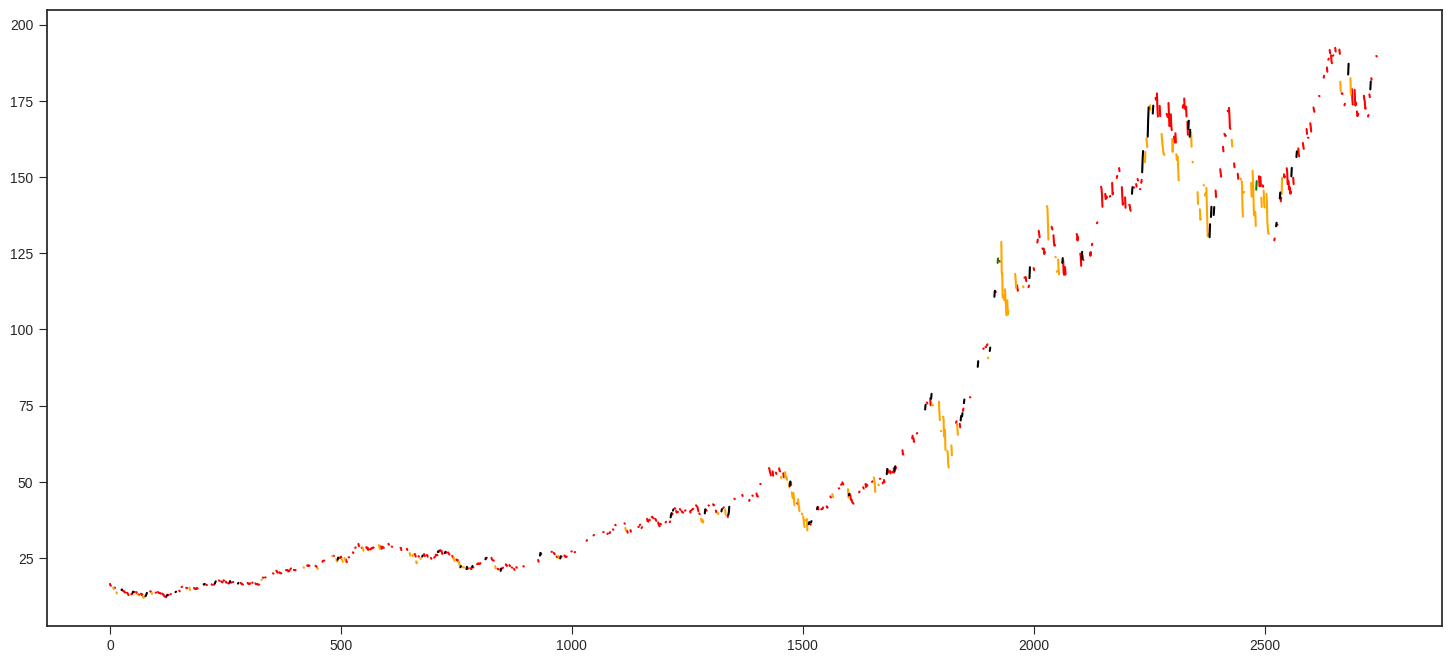

In [ ]:
# Plot Chart
fig = plt.figure(figsize= (18, 8))
plt.plot(labels_0, color="green")
plt.plot(labels_1, color="red")
plt.plot(labels_2, color="orange")
plt.plot(labels_3, color="black")
plt.show()

In [ ]:
from joblib import dump

dump(model, 'gaussian_hmm_aapl_model.joblib')

['gaussian_hmm_aapl_model.joblib']